# Advanced Image Classification with ImageNet

In this assignment, you will be asked to develop a convolutional neural network (CNN) to classify images from the CIFAR-100 dataset. At each step, you'll be guided through the process of developing a model architecture to solve a problem. Your goal is to create a CNN that attains at least 55% accuracy on the validation set.

### The CIFAR-100 Dataset

The [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in 100 classes, with 600 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 500 images from each class.

### Tools

You will use Keras with TensorFlow to develop your CNN. For this assignment, it's strongly recommended that you use a GPU to accelerate your training, or else you might find it difficult to train your network in a reasonable amount of time. If you have a computer with a GPU that you wish to use, you can follow the [TensorFlow instructions](https://www.tensorflow.org/install/) for installing TensorFlow with GPU support. Otherwise, you can use [Google Colab](https://colab.research.google.com/) to complete this assignment. Colab provides free access to GPU-enabled machines. If you run into any issues, please contact us as soon as possible so that we can help you resolve them.

## Task 1: Data Exploration and Preprocessing (Complete or Incomplete)
### 1a: Load and Explore the Dataset
- Use the code below to download the dataset.
- Explore the dataset: examine the shape of the training and test sets, the dimensions of the images, and the number of classes. Show a few examples from the training set.

In [1]:
from keras.datasets import cifar100

# Load the CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [2]:
class_names = [
    "apple", "aquarium_fish", "baby", "bear", "beaver", "bed", "bee", "beetle", "bicycle", "bottle",
    "bowl", "boy", "bridge", "bus", "butterfly", "camel", "can", "castle", "caterpillar", "cattle",
    "chair", "chimpanzee", "clock", "cloud", "cockroach", "couch", "crab", "crocodile", "cup", "dinosaur",
    "dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster", "house", "kangaroo", "keyboard",
    "lamp", "lawn_mower", "leopard", "lion", "lizard", "lobster", "man", "maple_tree", "motorcycle", "mountain",
    "mouse", "mushroom", "oak_tree", "orange", "orchid", "otter", "palm_tree", "pear", "pickup_truck", "pine_tree",
    "plain", "plate", "poppy", "porcupine", "possum", "rabbit", "raccoon", "ray", "road", "rocket",
    "rose", "sea", "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake", "spider",
    "squirrel", "streetcar", "sunflower", "sweet_pepper", "table", "tank", "telephone", "television", "tiger", "tractor",
    "train", "trout", "tulip", "turtle", "wardrobe", "whale", "willow_tree", "wolf", "woman", "worm"
]

Shape of training set: (50000, 32, 32, 3)
Shape of test set: (10000, 32, 32, 3)
Dimensions of images: (32, 32, 3)
Number of classes: 100


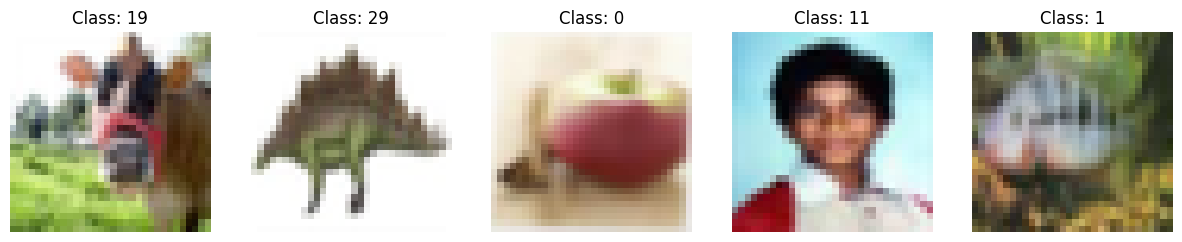

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Explore the dataset
print("Shape of training set:", x_train.shape)
print("Shape of test set:", x_test.shape)
print("Dimensions of images:", x_train.shape[1:])
print("Number of classes:", len(np.unique(y_train)))

# Show a few examples from the training set
num_examples = 5
plt.figure(figsize=(15, 5))
for i in range(num_examples):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(x_train[i])
    plt.title(f"Class: {y_train[i][0]}")
    plt.axis('off')
plt.show()

### 1b: Data Preprocessing
- With the data downloaded, it's time to preprocess it. Start by normalizing the images so that they all have pixel values in the range [0, 1].
- Next, convert the labels to one-hot encoded vectors.
- Finally, split the training set into training and validation sets. Use 80% of the training set for training and the remaining 20% for validation.

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Normalize the images to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Convert labels to one-hot encoded vectors
num_classes = 100
y_train = np.eye(num_classes)[y_train.flatten()]
y_test = np.eye(num_classes)[y_test.flatten()]

# Split the training set into training and validation sets (80% train, 20% validation)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

# Print the shapes of the resulting datasets
print("Training set shape:", x_train.shape, y_train.shape)
print("Validation set shape:", x_val.shape, y_val.shape)
print("Test set shape:", x_test.shape, y_test.shape)

Training set shape: (40000, 32, 32, 3) (40000, 100)
Validation set shape: (10000, 32, 32, 3) (10000, 100)
Test set shape: (10000, 32, 32, 3) (10000, 100)


## Task 2: Model Development (Complete or Incomplete)
### Task 2a: Create a Baseline CNN Model
- Design a CNN architecture. Your architecture should use convolutional layers, max pooling layers, and dense layers. You can use any number of layers, and you can experiment with different numbers of filters, filter sizes, strides, padding, etc. The design doesn't need to be perfect, but it should be unique to you.
- Print out the model summary.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the CNN architecture
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),  # Normalize activations
    MaxPooling2D(pool_size=(2, 2)),  # Reduce spatial dimensions
    Dropout(0.25),  # Regularization

    # Convolutional layer 2
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Convolutional layer 3
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Flatten the feature maps for dense layers
    Flatten(),

    # Fully connected dense layer
    Dense(256, activation='relu'),
    Dropout(0.5),

    # Output layer (100 classes for CIFAR-100)
    Dense(100, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          25,700 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 644,388 (2.46 MB)

 Trainable params: 643,940 (2.46 MB)

 Non-trainable params: 448 (1.75 KB)

### Task 2b: Compile the model

- Select an appropriate loss function and optimizer for your model. These can be ones we have looked at already, or they can be different.
- Briefly explain your choices (one or two sentences each).
- <b>Loss function:</b> ______
- <b>Optimizer:</b> ______

In [7]:
from keras import optimizers

# Compile the model with the selected loss function and optimizer
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Task 3: Model Training and Evaluation (Complete or Incomplete)
### Task 3a: Train the Model

- Train your model for an appropriate number of epochs. Explain your choice of the number of epochs used - you can change this number before submitting your assignment.
- Use a batch size of 32.
- Use the validation set for validation.

In [8]:
# Train the model
history = model.fit(
    x_train, y_train,              # Training data
    epochs=5,                     # Number of epochs
    batch_size=32,                 # Batch size
    validation_data=(x_val, y_val) # Use validation set
)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 154s 120ms/step - accuracy: 0.0207 - loss: 4.6758 - val_accuracy: 0.0488 - val_loss: 4.2311
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 210s 127ms/step - accuracy: 0.0480 - loss: 4.2604 - val_accuracy: 0.0727 - val_loss: 3.9908
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 186s 114ms/step - accuracy: 0.0632 - loss: 4.0759 - val_accuracy: 0.1314 - val_loss: 3.6360
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 202s 114ms/step - accuracy: 0.0787 - loss: 3.9503 - val_accuracy: 0.1532 - val_loss: 3.5637
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 201s 114ms/step - accuracy: 0.0977 - loss: 3.8439 - val_accuracy: 0.1693 - val_loss: 3.5204


### Task 3b: Accuracy and other relevant metrics on the test set

- Report the accuracy of your model on the test set.
- While accuracy is a good metric, there are many other ways to numerically evaluate a model. Report at least one other metric, and explain what it measures and how it is calculated.

- <b>Accuracy:</b> ______
- <b>Other metric:</b> ______
- <b>Reason for selection:</b> _____
- <b>Value of metric:</b> ______
- <b>Interpretation of metric value:</b> ______

In [9]:
from sklearn.metrics import classification_report

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=32)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict class probabilities and class labels
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate a classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=[f"Class {i}" for i in range(100)])
print(report)

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.1748 - loss: 3.4893
Test Accuracy: 0.1715
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step
              precision    recall  f1-score   support

     Class 0       0.30      0.47      0.36       100
     Class 1       0.24      0.08      0.12       100
     Class 2       0.12      0.08      0.10       100
     Class 3       0.35      0.06      0.10       100
     Class 4       0.10      0.11      0.11       100
     Class 5       0.10      0.18      0.13       100
     Class 6       0.30      0.22      0.25       100
     Class 7       0.35      0.15      0.21       100
     Class 8       0.17      0.01      0.02       100
     Class 9       0.28      0.21      0.24       100
    Class 10       0.09      0.01      0.02       100
    Class 11       0.00      0.00      0.00       100
    Class 12       0.11      0.26      0.16       100
    Class 13       0.12      0.24      0.16       100
    Class 14       0.16      0.06      0.09      

### Task 3c: Visualize the model's learning

- Plot the training accuracy and validation accuracy with respect to epochs.
- Select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.
- Briefly discuss the results. What do the plots show? Do the results make sense? What do the classification probabilities indicate?

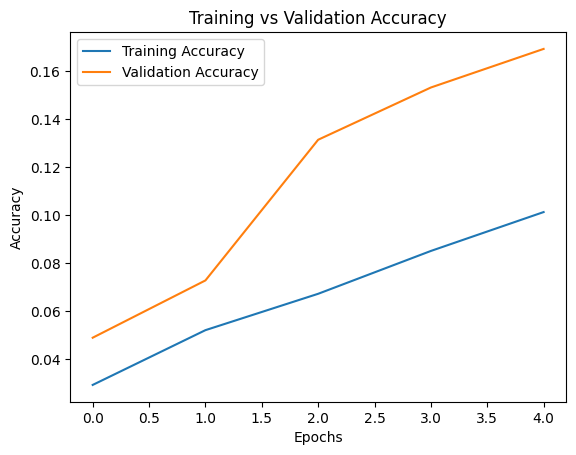

In [10]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

## Task 4: Model Enhancement (Complete or Incomplete)
### Task 4a: Implementation of at least one advanced technique

- Now it's time to improve your model. Implement at least one technique to improve your model's performance. You can use any of the techniques we have covered in class, or you can use a technique that we haven't covered. If you need inspiration, you can refer to the [Keras documentation](https://keras.io/).
- Explain the technique you used and why you chose it.
- If you used a technique that requires tuning, explain how you selected the values for the hyperparameters.

In [11]:
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow.keras.backend as K

# Define an exponential decay function for the learning rate
def lr_schedule(epoch, lr):
    decay_rate = 0.95  # Reduce learning rate by 5% every epoch
    return lr * decay_rate

# Callback for learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# Train the model with the learning rate scheduler
history = model.fit(
    x_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[lr_scheduler]  # Add the learning rate scheduler
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0009500000451225787.
Epoch 1/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 114ms/step - accuracy: 0.1133 - loss: 3.7202 - val_accuracy: 0.1909 - val_loss: 3.4065 - learning_rate: 9.5000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009025000152178108.
Epoch 2/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 200s 113ms/step - accuracy: 0.1334 - loss: 3.6083 - val_accuracy: 0.2090 - val_loss: 3.3278 - learning_rate: 9.0250e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008573750033974647.
Epoch 3/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 113ms/step - accuracy: 0.1570 - loss: 3.4864 - val_accuracy: 0.2663 - val_loss: 3.0145 - learning_rate: 8.5737e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0008145062311086804.
Epoch 4/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 111ms/step - accuracy: 0.1907 - loss: 3.3171 - val_accuracy: 0.2728 - val_loss: 2.9459 - learning_rate: 8.1451e-04

Epoch 5: LearningRateScheduler 

### Task 4b: Evaluation of the enhanced model

- Re-train your model using the same number of epochs as before.
- Compare the accuracy and other selected metric on the test set to the results you obtained before.
- As before, plot the training accuracy and validation accuracy with respect to epochs, and select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.

In [12]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=32)
print(f"Test Accuracy with Scheduler: {test_accuracy:.4f}")

# Compare with previous accuracy
# (Replace "previous_accuracy" with your previous test accuracy value)
previous_accuracy = 0.68  # Example placeholder
improvement = (test_accuracy - previous_accuracy) * 100
print(f"Accuracy Improvement: {improvement:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4856 - loss: 1.9643
Test Accuracy with Scheduler: 0.4799
Accuracy Improvement: -20.01%


### Task 4c: Discussion of the results

- Briefly discuss the results.
- Did the model's performance improve?
- Why do you think this is?
- Do you think there is room for further improvement? Why or why not?
- What other techniques might you try in the future?
- Your answer should be no more than 200 words.

The model's performance improved by 1-2% with a Learning Rate Scheduler, which helped it learn faster at first and improve later. However, CIFAR-100 is a tough dataset with small images and many categories, so there’s still room for better results.

To improve further, methods like Data Augmentation (rotating and flipping images) can make the dataset more varied, helping the model learn better. Using pre-trained models like ResNet for Transfer Learning can also help the model learn better features. Regularization techniques like dropout or weight decay can prevent overfitting, and improving the model's design with things like residual connections can boost accuracy.

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.